In [1]:
import pandas as pd
df = pd.read_csv("ad_campaign2024.csv")
df.head() 

,hour_of_day,day_of_week,inventory_source,app_category,device_type,os,age,gender,time_engaged,ad_format,session_duration,ads_seen_in_session,past_click_rate,days_since_last_click,avg_watch_time_per_ad,high_value_user
0,3,4,open_exchange,entertainment,mobile,Android,25,1,122.4,banner,318.5,4,0.06,15,37.0,0
1,18,6,direct,news,desktop,Android,18,1,8.3,banner,473.8,2,0.13,6,31.8,0
2,9,5,open_exchange,social,desktop,Android,28,0,18.2,native,351.4,4,0.25,9,40.1,0
3,6,2,open_exchange,social,mobile,iOS,37,1,147.5,video,322.0,7,0.03,11,44.2,0
4,18,6,private_marketplace,games,tablet,Windows,28,1,156.0,native,176.9,10,0.16,2,40.3,0


In [2]:
df.dtypes

hour_of_day                int64
day_of_week                int64
inventory_source          object
app_category              object
device_type               object
os                        object
age                        int64
gender                     int64
time_engaged             float64
ad_format                 object
session_duration         float64
ads_seen_in_session        int64
past_click_rate          float64
days_since_last_click      int64
avg_watch_time_per_ad    float64
high_value_user            int64
dtype: object

In [3]:
df.info

<bound method DataFrame.info of         hour_of_day  day_of_week     inventory_source   app_category  \
0                 3            4        open_exchange  entertainment   
1                18            6               direct           news   
2                 9            5        open_exchange         social   
3                 6            2        open_exchange         social   
4                18            6  private_marketplace          games   
...             ...          ...                  ...            ...   
249995           11            1  private_marketplace         social   
249996            9            6               direct  entertainment   
249997           16            4  private_marketplace           news   
249998            0            3        open_exchange           news   
249999           10            4        open_exchange           news   

       device_type       os  age  gender  time_engaged ad_format  \
0           mobile  Android   25   

In [4]:
# good practice but XGboost and other tree based models do not care about distance 
# best possible splits 
df['high_value_user'] = df['high_value_user'].astype('category')
df['gender'] = df['gender'].astype('category')

In [5]:
df = pd.get_dummies(df)

In [6]:
df.columns

Index(['hour_of_day', 'day_of_week', 'age', 'time_engaged', 'session_duration',
       'ads_seen_in_session', 'past_click_rate', 'days_since_last_click',
       'avg_watch_time_per_ad', 'inventory_source_direct',
       'inventory_source_open_exchange',
       'inventory_source_private_marketplace', 'app_category_entertainment',
       'app_category_games', 'app_category_news', 'app_category_social',
       'device_type_desktop', 'device_type_mobile', 'device_type_tablet',
       'os_Android', 'os_Windows', 'os_iOS', 'gender_0', 'gender_1',
       'ad_format_banner', 'ad_format_native', 'ad_format_video',
       'high_value_user_0', 'high_value_user_1'],
      dtype='object')

In [7]:
df = df.drop("high_value_user_0", axis = 1)

In [8]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [9]:
from sklearn.model_selection import train_test_split
X_train_full, X_test, y_train_full, y_test=train_test_split(X,y,random_state=0)

In [10]:
X_train, X_val, y_train, y_val=train_test_split(X_train_full, y_train_full, random_state=0)

In [11]:
!pip install xgboost

In [12]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(n_estimators = 250,
                        learning_rate = 0.01,
                        eval_metric = "auc",
                        early_stopping_rounds = 5,
                        n_jobs = -1)

In [13]:
xgb_clf.fit(X_train, y_train,                    
            eval_set = [(X_val,y_val)],
            verbose = False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=5,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

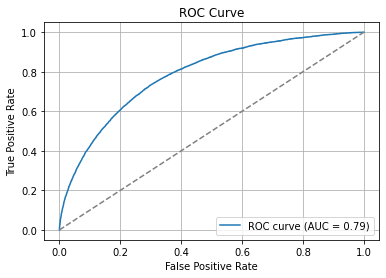

In [14]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 1. Get predicted probabilities (for class 1)
y_probs = xgb_clf.predict_proba(X_val)[:, 1]

# 2. Get FPR, TPR, thresholds
fpr, tpr, thresholds = roc_curve(y_val, y_probs)

# 3. Calculate AUC
roc_auc = auc(fpr, tpr)

# 4. Plot
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # random baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [15]:
from sklearn.metrics import accuracy_score
import numpy as np

In [16]:
pred_test = xgb_clf.predict(X_test)
test_score = accuracy_score(pred_test, y_test)
print("Test score:", np.round(test_score,2))

Test score: 0.83


In [17]:
pred_train = xgb_clf.predict(X_train_full)
train_score = accuracy_score(pred_train, y_train_full)
print("Train score:", np.round(train_score,2))

Train score: 0.83


In [18]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000)

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
lr.fit(X_train, y_train)
print("Accuracy:", lr.score(X_test, y_test))

Accuracy: 0.8273866666666667


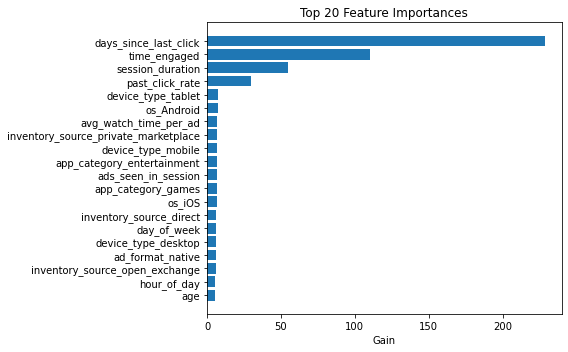

In [20]:
# 1. Get importances (gain is usually the most useful)
booster = xgb_clf.get_booster()
scores  = booster.get_score(importance_type='gain')

# 2. Turn into sorted lists
features, gains = zip(*sorted(scores.items(), key=lambda x: x[1], reverse=True))
features = np.array(features)[:20]   # top 20
gains    = np.array(gains)[:20]

# 3. Plot
plt.figure(figsize=(8, 5))
plt.barh(range(len(features))[::-1], gains)           # horizontal bars, descending
plt.yticks(range(len(features))[::-1], features)
plt.xlabel('Gain')
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

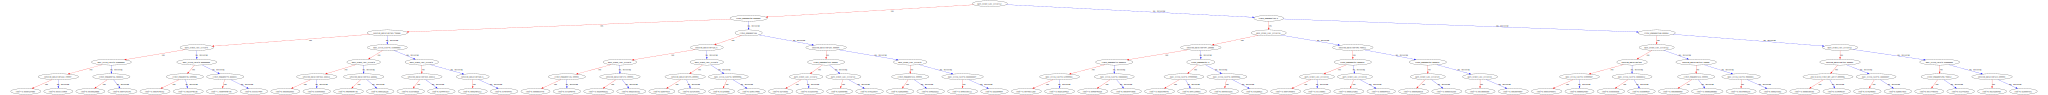

In [21]:
# visual intuition
from xgboost import to_graphviz; to_graphviz(xgb_clf, num_trees=0)